### Goals:
- Extract features from the photographs taken with a camera setup on the vehicle.
- Use the extracted features to find matches between the features in different photographs.
- Use the found matches to estimate the camera motion between subsequent photographs.
- Use the estimated camera motion to build the vehicle trajectory.

Coursera: https://www.coursera.org/learn/visual-perception-self-driving-cars/ungradedLab/TX6tn/practice-assignment-applying-stereo-depth-to-a-driving-scenario/lab?path=%2Fnotebooks%2Fmodule2%2FVisual%2520Odometry%2520for%2520Localization%2520in%2520Autonomous%2520Driving.ipynb 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from m2bk import *

## Loading and Visualizing the Data

The dataset handler contains 52 data frames. Each frame contains an RGB image and a depth map taken with a setup on the vehicle and a grayscale version of the RGB image which will be used for computation. Furthermore, camera calibration matrix K is also provided in the dataset handler

The frame content can be accessed by using `images`, `images_rgb`, `depth_maps` attributes of the dataset handler object along with the index of the requested frame. See how to access the images below

In [4]:
dataset_handler = DatasetHandler()

# Need to add a camera calibration matrix when using our own data set

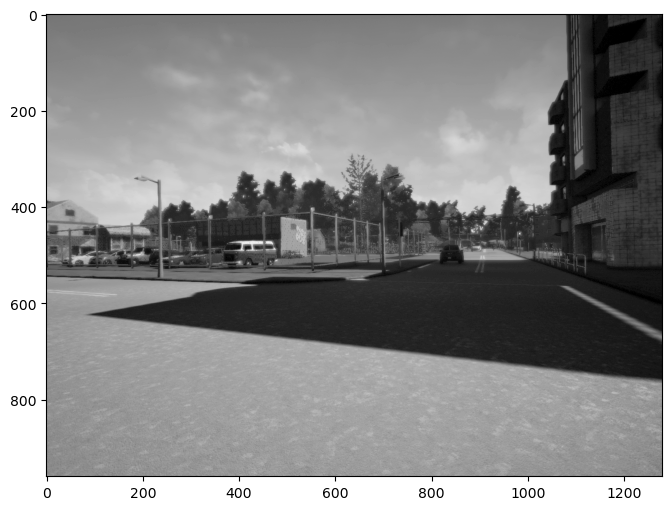

In [5]:
# show gray image
image = dataset_handler.images[0]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image, cmap='gray')
plt.show()

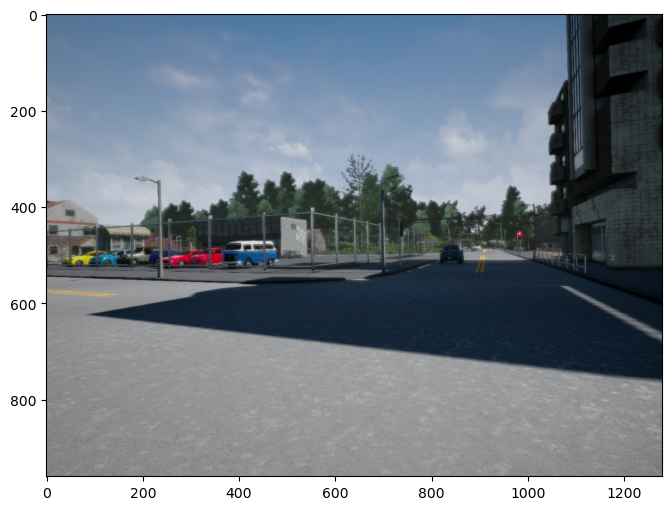

In [6]:
# show rgb image
image_rgb = dataset_handler.images_rgb[0]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image_rgb)
plt.show()

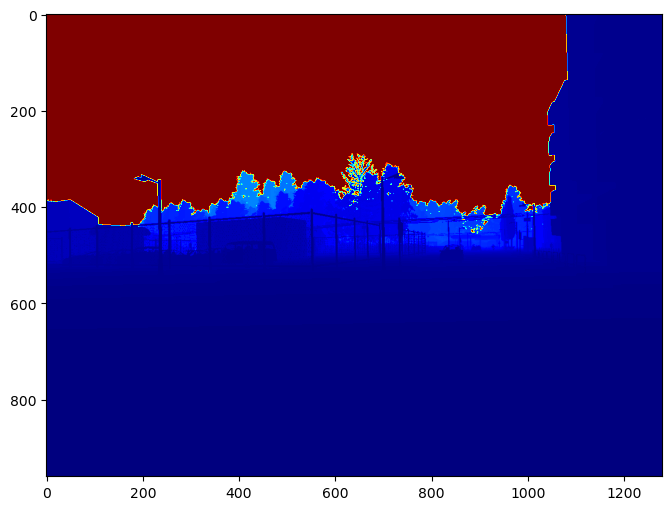

In [7]:
# show depth
i = 0
depth = dataset_handler.depth_maps[i]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(depth, cmap='jet')
plt.show()

In [8]:
print("Depth map shape: {0}".format(depth.shape))

v, u = depth.shape
depth_val = depth[v-1, u-1]
print("Depth value of the very bottom-right pixel of depth map {0} is {1:0.3f}".format(i, depth_val))

Depth map shape: (960, 1280)
Depth value of the very bottom-right pixel of depth map 0 is 1.862


In [9]:
# k - camera calibration matrix
dataset_handler.k

array([[640.,   0., 640.],
       [  0., 480., 480.],
       [  0.,   0.,   1.]], dtype=float32)

## 1 - Feature Extraction

### 1.1 - Extracting Features from an Image

__Task:__ Implement feature extraction from a single image.

- Make sure you understand the structure of the keypoint descriptor object, this will be very useful for your further tasks. You might find [OpenCV: Keypoint Class Description](https://docs.opencv.org/3.4.3/d2/d29/classcv_1_1KeyPoint.html) handy. 

- Make sure you understand the image coordinate system, namely the origin location and axis directions.

- We provide you with a function to visualise the features detected. Run the last 2 cells in section 1.1 to view.

- Optional: Try to extract features with different descriptors such as SIFT, ORB, SURF and BRIEF. You can also try using detectors such as Harris corners or FAST and pairing them with a descriptor. Lastly, try changing parameters of the algorithms. Do you see the difference in various approaches? You might find this link useful: [OpenCV:Feature Detection and Description](https://docs.opencv.org/3.4.3/db/d27/tutorial_py_table_of_contents_feature2d.html).

In [11]:
print("OpenCV version:", cv2.__version__)


OpenCV version: 4.10.0


In [12]:
def extract_features(image):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    # Create SIFT object
    sift = cv2.xfeatures2d.SIFT_create()
    # Detect keypoints and compute descriptors
    kp, des = sift.detectAndCompute(image, None)

    # Here kp will be a list of keypoints and des is a numpy array of shape Number_of_Keypoints×128.
    
    return kp, des

In [13]:
i = 0
image = dataset_handler.images[i]
kp, des = extract_features(image)
print(kp[1].pt)
print("Number of features detected in frame {0}: {1}\n".format(i, len(kp)))

print("Coordinates of the first keypoint in frame {0}: {1}".format(i, str(kp[0].pt)))

(4.180478096008301, 457.4769287109375)
Number of features detected in frame 0: 1508

Coordinates of the first keypoint in frame 0: (4.180478096008301, 457.4769287109375)


[ WARN:0@47.230] global shadow_sift.hpp:13 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


In [17]:
def visualize_features(image, kp):
    """
    Visualize extracted features in the image

    Arguments:
    image -- a grayscale image
    kp -- list of the extracted keypoints

    Returns:
    """
    display = cv2.drawKeypoints(image, kp, None, color=(0,255,0), flags=0)
    plt.imshow(display)
    plt.show()

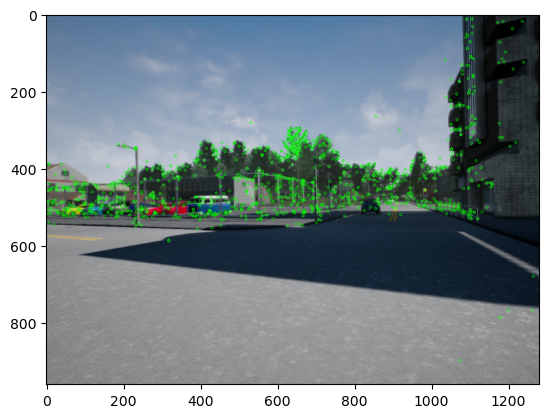

In [18]:
# Optional: visualizing and experimenting with various feature descriptors
i = 0
image = dataset_handler.images_rgb[i]

visualize_features(image, kp)

### 1.2 - Extracting Features from Each Image in the Dataset
__Task:__ Implement feature extraction for each image in the dataset with the function you wrote in the above section.



In [19]:
def extract_features_dataset(images, extract_features_function):
    """
    Find keypoints and descriptors for each image in the dataset

    Arguments:
    images -- a list of grayscale images
    extract_features_function -- a function which finds features (keypoints and descriptors) for an image

    Returns:
    kp_list -- a list of keypoints for each image in images
    des_list -- a list of descriptors for each image in images
    
    """
    kp_list = []
    des_list = []
    
    for img in images:
        # extract keypoints and descriptors
        kp, des = extract_features_function(img)
        kp_list.append(kp)
        des_list.append(des)
    
    return kp_list, des_list

In [20]:
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)

i = 0
print("Number of features detected in frame {0}: {1}".format(i, len(kp_list[i])))
print("Coordinates of the first keypoint in frame {0}: {1}\n".format(i, str(kp_list[i][0].pt)))

# Remember that the length of the returned by dataset_handler lists should be the same as the length of the image array
print("Length of images array: {0}".format(len(images)))

Number of features detected in frame 0: 1508
Coordinates of the first keypoint in frame 0: (4.180478096008301, 457.4769287109375)

Length of images array: 52


## 2 - Feature Matching

Next step after extracting the features in each image is matching the features from the subsequent frames. This is what is needed to be done in this section.

### 2.1 - Matching Features from a Pair of Subsequent Frames [FILTERED]
__Task:__ Implement feature matching for a pair of images. You can use any feature matching algorithm of your choice covered in the lectures, Brute Force Matching or FLANN based Matching for example.

- Optional 1: Implement match filtering by thresholding the distance between the best matches. This might be useful for improving your overall trajectory estimation results. Recall that you have an option of specifying the number best matches to be returned by the matcher.
- We have provided a visualization of the found matches. Do all the matches look legitimate to you? Do you think match filtering can improve the situation?

In [27]:
def filter_match_features(des1, des2, dist_threshold):
    """
    Match features from two images. 
    Filter matched features from two images by distance between the best matches.

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    match -- list of matched features from two images. Each match[i] is k or less matches for the same query descriptor
    """
    # Brute Force matching
    bf = cv2.BFMatcher()

    # BFMatcher.knnMatch() to get k best matches. In this example, we will take k=2 so that we can apply ratio test explained by D.Lowe in his paper.
    match = bf.knnMatch(des1,des2,k=2)

    filtered_match = []
    # add feature to new list if lower than threshold
    for m,n in match:
        if m.distance < (dist_threshold * n.distance):
            filtered_match.append([m])
    
    return filtered_match

In [28]:
i = 10
des1 = des_list[i]
des2 = des_list[i+1]

filtered_match = filter_match_features(des1, des2, dist_threshold=0.6)
print("Number of features matched in frames {0} and {1} after filtering by distance: {2}".format(i, i+1, len(filtered_match)))

# print(len(des1))
# print(len(des2))
# print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(match)))
# print(match[1])

# Remember that a matcher finds the best matches for EACH descriptor from a query set

Number of features matched in frames 10 and 11 after filtering by distance: 428


In [32]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """    
    # draw lines to match the features 
#     image_matches = cv2.drawMatches(image1,kp1,image2,kp2,match,None)
    image_matches = cv2.drawMatchesKnn(image1,kp1,image2,kp2,match,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # show the two images with n matched features
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)
    plt.show()

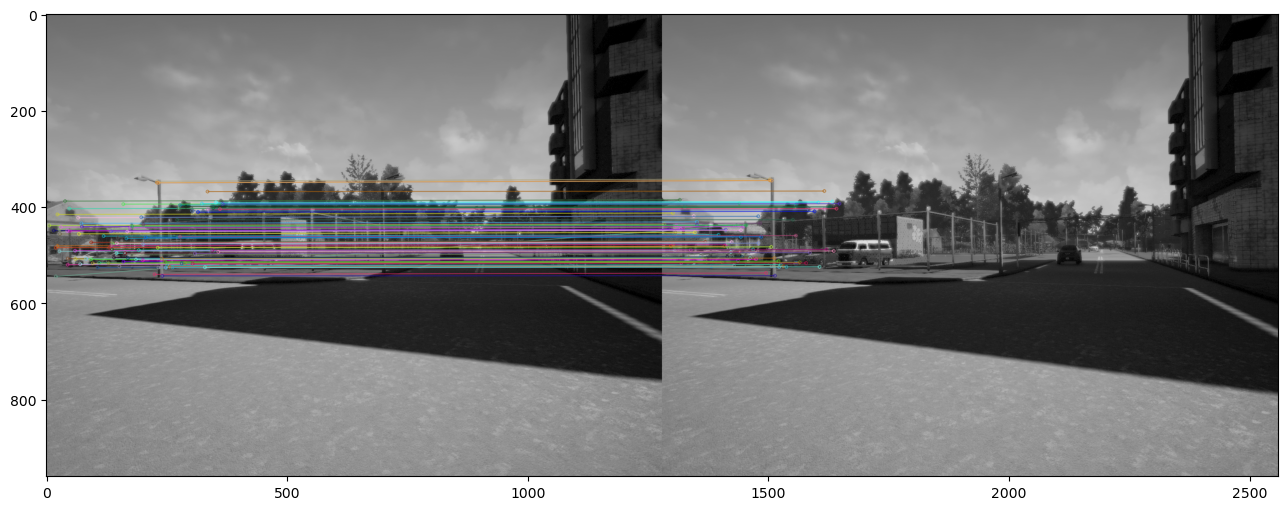

In [34]:
# # Visualize n first matches, set n to None to view all matches
# # set filtering to True if using match filtering, otherwise set to False
n = 100
filtering = True

i = 0 

# initialize images
image1 = dataset_handler.images[i]
image2 = dataset_handler.images[i+1]

# keypoint 
kp1 = kp_list[i]
kp2 = kp_list[i+1]

# descriptors
des1 = des_list[i]
des2 = des_list[i+1]

# outImg = np.empty((1,1))

if filtering:
    match = filter_match_features(des1, des2, dist_threshold=0.6)
    
# print(len(match))
image_matches = visualize_matches(image1, kp1, image2, kp2, match[:n])  


### 2.2 - Matching Features in Each Subsequent Image Pair in the Dataset [FILTERED]

__Task:__ Implement feature matching for each subsequent image pair in the dataset with the function you wrote in the above section.

Optional: Implement match filtering by thresholding the distance for each subsequent image pair in the dataset with the function you wrote in the above section.

In [ ]:
def filter_match_features_dataset(des_list, filter_match_features):
    """
    Match features for each subsequent image pair in the dataset
    Filter matched features by distance for each subsequent image pair in the dataset

    Arguments:
    des_list -- a list of descriptors for each image in the dataset
    filter_match_features -- a function which maches features between a pair of images

    Returns:
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    filtered_matches -- list of good matches for each subsequent image pair in the dataset. 
                        Each matches[i] is a list of good matches, satisfying the distance threshold
               
    """
    matches = []
    
    # matches features in image i and i+1
    for i in range(len(des_list)-1):
        matches.append(filter_match_features(des_list[i], des_list[i+1], dist_threshold=0.6))
                       
    # return matches

    filtered_matches = []
    filtered_list = []
    
    for match in matches:
        filtered_list = filter_matches_distance(match, dist_threshold)
        filtered_matches.append(filtered_list)
    
    return filtered_matches

In [ ]:
matches = match_features_dataset(des_list, filter_match_features)

i = 0
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))
# print(matches[0])

In [ ]:
def filter_matches_dataset(filter_matches_distance, matches, dist_threshold):
    """
    Filter matched features by distance for each subsequent image pair in the dataset

    Arguments:
    filter_matches_distance -- a function which filters matched features from two images by distance between the best matches
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_matches -- list of good matches for each subsequent image pair in the dataset. 
                        Each matches[i] is a list of good matches, satisfying the distance threshold
               
    """
    filtered_matches = []
    filtered_list = []
    
    for match in matches:
        filtered_list = filter_matches_distance(match, dist_threshold)
        filtered_matches.append(filtered_list)
    
    return filtered_matches

In [ ]:
# Optional
dist_threshold = 0.6

filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)

if len(filtered_matches) > 0:
    
    # Make sure that this variable is set to True if you want to use filtered matches further in your assignment
    is_main_filtered_m = True
    if is_main_filtered_m: 
        matches = filtered_matches

    i = 0
    print("Number of filtered matches in frames {0} and {1}: {2}".format(i, i+1, len(filtered_matches[i])))

# 3 - Trajectory Estimation
At this point you have everything to perform visual odometry for the autonomous vehicle. In this section you will incrementally estimate the pose of the vehicle by examining the changes that motion induces on the images of its onboard camera.

## 3.1 - Estimating Camera Motion between a Pair of Images
__Task:__ Implement camera motion estimation from a pair of images. You can use the motion estimation algorithm covered in the lecture materials, namely Perspective-n-Point (PnP), as well as Essential Matrix Decomposition.

If you decide to use PnP, you will need depth maps of frame and they are provided with the dataset handler. Check out Section 0 of this assignment to recall how to access them if you need. As this method has been covered in the course, review the lecture materials if need be.
If you decide to use Essential Matrix Decomposition, more information about this method can be found in [Wikipedia: Determining R and t from E](https://en.wikipedia.org/wiki/Essential_matrix).
More information on both approaches implementation can be found in [OpenCV: Camera Calibration and 3D Reconstruction](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html). Specifically, you might be interested in Detailed Description section of [OpenCV: Camera Calibration and 3D Reconstruction](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html) as it explains the connection between the 3D world coordinate system and the 2D image coordinate system.

Optional: Implement camera motion estimation with PnP, PnP with RANSAC and Essential Matrix Decomposition. Check out how filtering matches by distance changes estimated camera movement. Do you see the difference in various approaches?

In [ ]:
def estimate_motion(match, kp1, kp2, k, depth1):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera calibration matrix 
    
    Optional arguments:
    depth1 -- a depth map of the first frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    rmat -- recovered 3x3 rotation numpy matrix
    tvec -- recovered 3x1 translation numpy vector
    image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
    image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
               
    """
#     rmat = np.eye(3)
#     tvec = np.zeros((3, 1))
#     image1_points = []
#     image2_points = []
    
#     min_len = min(len(kp1), len(kp2))

#     # Iterate through the matched features
#     for m in match:
# #         print(m)
#         # check the number of matched features isnt greater than keypoints
#         if m[0].queryIdx >= min_len:
#             break
#         # Get the pixel coordinates of features f[k] and f[k+1]
# #         print(m.queryIdx)
#         u1, v1 = kp1[m[0].queryIdx].pt
#         u2, v2 = kp2[m[0].queryIdx].pt

#         # 2D points
#         image1_points.append([u1,v1])
#         image2_points.append([u2, v2])
        

#     # Find fundamental matrix
#     F = cv.findFundamentalMat(np.array(image1_points),  np.array(image2_points))
    
#     # Take the first 9 values and reshape into a 3x3 matrix 
#     Mat_E = k.transpose() * F[0] * k;


#     # decompose essential matrix into R, t (See Hartley and Zisserman 9.13)
#     U, S, Vt = np.linalg.svd(Mat_E)
#     W = np.array([0.0, -1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]).reshape(3, 3)

#     R = U.dot(W).dot(Vt)
#     T = U[:, 2]
#     T = T.reshape(-1, 1)
    
#     return R, T, image1_points, image2_points

    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = []
    image2_points = []
    
    objectpoints = []

    # Iterate through the matched features
    for m in match:
        # Get the pixel coordinates of features f[k - 1] and f[k]
        u1, v1 = kp1[m[0].queryIdx].pt
        u2, v2 = kp2[m[0].trainIdx].pt

        # Get the scale of features f[k - 1] from the depth map
        s = depth1[int(v1), int(u1)]

        # Check for valid scale values
        if s < 1000:
            # Transform pixel coordinates to camera coordinates using the pinhole camera model
            p_c = np.linalg.inv(k) @ (s * np.array([u1, v1, 1]))

            # Save the results
            image1_points.append([u1, v1])
            image2_points.append([u2, v2])
            objectpoints.append(p_c)

    # Convert lists to numpy arrays
    objectpoints = np.vstack(objectpoints)
    imagepoints = np.array(image2_points)

    # Determine the camera pose from the Perspective-n-Point solution using the RANSAC scheme
    _, rvec, tvec, _ = cv2.solvePnPRansac(objectpoints, imagepoints, k, None)

    # Convert rotation vector to rotation matrix
    rmat, _ = cv2.Rodrigues(rvec)
    
    return rmat, tvec, image1_points, image2_points


In [ ]:
i = 9
match = matches[i] # get matches btwn img0 and img1
kp1 = kp_list[i] # keypoints of img0
kp2 = kp_list[i+1] # keypoints of img1
k = dataset_handler.k
depth = dataset_handler.depth_maps[i]

rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k, depth1=depth)

print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))

__Expected Output Format:__

Make sure that your estimated rotation matrix and translation vector are in the same format as the given initial values

rmat = np.eye(3)
tvec = np.zeros((3, 1))

print("Initial rotation:\n {0}".format(rmat))
print("Initial translation:\n {0}".format(tvec))
Initial rotation:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Initial translation:
 [[0.]
 [0.]
 [0.]]

__Camera Movement Visualization:__ You can use visualize_camera_movement that is provided to you. This function visualizes final image matches from an image pair connected with an arrow corresponding to direction of camera movement (when is_show_img_after_mov = False). The function description:

Arguments:
image1 -- the first image in a matched image pair (RGB or grayscale)
image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [x, y], where x and y are 
                 coordinates of the i-th match in the image coordinate system
image2 -- the second image in a matched image pair (RGB or grayscale)
image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [x, y], where x and y are 
                 coordinates of the i-th match in the image coordinate system
is_show_img_after_mov -- a boolean variable, controling the output (read image_move description for more info) 

Returns:
image_move -- an image with the visualization. When is_show_img_after_mov=False then the image points from both images are visualized on the first image. Otherwise, the image points from the second image only are visualized on the second image

In [ ]:
i=0
image1  = dataset_handler.images_rgb[i]
image2 = dataset_handler.images_rgb[i + 1]

# plt.imshow(image1)
plt.imshow(image2)

image_move = visualize_camera_movement(image1, image1_points, image2, image2_points, False)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)